In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
import numpy as np
import os


instr = 'maxi'
# instr = 'xrt'

os.makedirs(f"plots/{instr}",exist_ok=True)

# Define the pattern to match the CSV files
file_pattern = '/disk/data/youssef/scripts/xrb-population/results_latest/'+instr+'_results/*.csv'
# csv_files = [file for file in glob(file_pattern) if "full" not in file]
csv_files = [file for file in glob(file_pattern) if "full" in file]

# csv_files = [file for file in csv_files if "T0.3" not in file]
# csv_files = [file for file in csv_files if "r0.7" not in file]
 
# Function to extract parameter values from filenames
def extract_parameters(filename):
    pattern = r'table_g(?P<g>\d+\.\d+)_T(?P<T>\d+\.\d+)_a(?P<a>\d+\.\d+)_m(?P<m>\d+\.\d+)_i(?P<i>\d+\.\d+)_r(?P<r>\d+\.\d+)_e(?P<e>\d+\.\d+)_full\.csv'
    match = re.search(pattern, filename)
    if match:
        return {key: float(value) for key, value in match.groupdict().items()}
    else:
        return None

def calc_MAE(scale,l_err,u_err):
        return ((u_err-l_err)/2)/scale

def weighted_median(values, weights):
    if len(values) != 0:
        """
        Compute the weighted median of a 1D numpy array `values` 
        with positive `weights`.
        """
        # Sort by values
        sort_idx = np.argsort(values)
        sorted_values = values[sort_idx]
        sorted_weights = weights[sort_idx]

        # Compute the cumulative sum of weights
        cumulative_weights = np.cumsum(sorted_weights)
        total_weight = cumulative_weights[-1]

        # Find the index where cumulative weight exceeds total_weight/2
        midpoint = 0.5 * total_weight
        median_idx = np.searchsorted(cumulative_weights, midpoint, side='right')
        return sorted_values[median_idx]
    else:
        return None

def find_peak(array):
    if len(array) != 0:
        counts, bins = np.histogram(array,bins='stone')
        peak = (bins[np.argmax(counts)]+bins[np.argmax(counts)+1])/2
    else:
        peak = None
    return peak

def distall_full_data(dataFrame):
        
        nH_list = dataFrame["nH"].unique()
        d_list = dataFrame["d"].unique()
        table_red = []

        for nH_value in nH_list:
            for d in d_list: 

                filtered_results = dataFrame[(dataFrame["d"] == d) & (dataFrame["nH"] == nH_value)]
                df = pd.DataFrame(filtered_results)
                peak = (find_peak(df['d_fit'].dropna().to_numpy())) if 'd_fit' in df.columns else None
                peak_flux = (find_peak(df['total_flux'].dropna().to_numpy())) if 'total_flux' in df.columns else None
                weightedMedian = weighted_median(df["d_fit"].dropna().to_numpy(),(1/calc_MAE(df["d_fit"].dropna().to_numpy(),df['error_d_low'].dropna().to_numpy(),df['error_d_up'].dropna().to_numpy())))
                table_red.append({
                    "nH": nH_value,
                    "red_chi_squared": df["red_chi_squared"].median() if 'red_chi_squared' in df.columns else None,
                    "gamma": df["gamma"].median() if 'gamma' in df.columns else None,
                    "power_norm_fake": df.loc[0:1, 'power_norm_fake'] if 'power_norm_fake' in df.columns else None,
                    "power_norm_fit": df["power_norm_fit"].median() if 'power_norm_fit' in df.columns else None,
                    "temp": df["temp"].median() if 'temp' in df.columns else None,
                    "disk_norm_fake": df.loc[0:1, 'disk_norm_fake'] if 'disk_norm_fake' in df.columns else None,
                    "disk_norm_fit": df["disk_norm_fit"].median() if 'disk_norm_fit' in df.columns else None,
                    "error_disk_norm": (df["disk_norm_fit"].median() - df.loc[0:1, 'disk_norm_fake']) if 'disk_norm_fit' in df.columns else None,
                    "d": d,
                    "d_fit": df["d_fit"].median() if 'd_fit' in df.columns else None,
                    "error_d": (df["d_fit"].median() - d) if 'd_fit' in df.columns else None,
                    "frac_uncert": ((df["d_fit"].median() - d) / d) if 'd_fit' in df.columns else None,
                    "d_fit_peak": peak,
                    "error_d_peak": (peak-d) if peak else None,
                    "frac_uncert_peak": ((peak-d) / d) if peak else None,
                    "med_frac_uncert": df["frac_uncert"].median() if 'frac_uncert' in df.columns else None,
                    "total_flux": df["total_flux"].median() if 'total_flux' in df.columns else None,
                    "peak_flux": peak_flux,
                    "d_fit_weighted_median": weightedMedian
                })

        return pd.DataFrame(table_red)

# List to store summary statistics
summary_data = []

# Initialize an empty list to store distances
distances = []

# Initialize an empty list to store distances with non-available 'frac_uncert'
na_distances = []

# Initialize an empty list to all data
all_data = []

# Initialize a dictionary to store filenames with non-available 'd_fit'
na_d_fit_files = []

na_d_fit_params = []

na_nH = []

all_data_params= []

central_value = 'd_fit_weighted_median'  

# Process each file
for file in csv_files:
    parameters = extract_parameters(file)
    if parameters:
        # try:
        data = pd.read_csv(file)    
        
        # Reduced dataframe
        data = distall_full_data(data)
        
        # Filter rows where the absolute fractional uncertainty is less than 0.5
        
        # filtered_data = data[abs(data['frac_uncert']) < 10]
        
        
        # filtered_data2 = data[abs(data['frac_uncert']) < 0.5]
        filtered_data2 = data[data[central_value].notna()]
        
        # Append the distances ('d') to the list
        distances.extend(filtered_data2['d'].values)
        na_data = data[data[central_value].isna()]
        na_distances.extend(na_data['d'].values)
        na_nH.extend(na_data['nH'].values)

        all_data.append(data[['nH', 'd', 'frac_uncert',central_value]])
        all_data_params.append(parameters)

        selected_data = data[data['d']==1]

        # Check if 'd_fit' contains NaN and store filename if true
        if selected_data[central_value].isna().any():
            na_d_fit_files.append(os.path.basename(file))
            # Extract parameters from the filename using regex
            na_d_fit_params.append(parameters)
        # except Exception as e:
        #     print(f"Error processing file {file}: {e}")

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
import numpy as np
import os
import warnings

# For progress bar
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable, desc=""):
        return iterable

# ---------------------------------------------------------------------
# 1) Configuration / Setup
# ---------------------------------------------------------------------

# 1a) Suppress warnings
warnings.filterwarnings(
    "ignore",
    message="The number of bins estimated may be suboptimal."
)
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message="DataFrameGroupBy.apply operated on the grouping columns"
)

# 1b) Instrument, file patterns, output directory
instr = 'maxi'
os.makedirs(f"plots/{instr}", exist_ok=True)

file_pattern_full = (
    f'/disk/data/youssef/scripts/xrb-population/results_latest/{instr}_results/*full*.csv'
)
file_pattern_agg  = (
    f'/disk/data/youssef/scripts/xrb-population/results_latest/{instr}_results/*.csv'
)

# Identify the files
csv_files_full = [f for f in glob(file_pattern_full)]
csv_files_agg  = [f for f in glob(file_pattern_agg) if "full" not in f]

# The columns we ultimately want in the aggregated file
all_needed_cols = [
    "red_chi_squared", "gamma", "temp", "power_norm_fit",
    "disk_norm_fit", "total_flux_median", "d_fit_median",
    "d_fit_peak", "peak_flux", "d_fit_weighted_median",
    "error_d_median", "frac_uncert_median", "error_d_peak",
    "frac_uncert_peak"
]

# This is the central column (distance statistic) used for filtering
central_value = "d_fit_weighted_median"

# ---------------------------------------------------------------------
# 2) Global Data Structures
# ---------------------------------------------------------------------
# Same structures from your original script
distances       = []
na_distances    = []
na_nH           = []
all_data        = []
na_d_fit_files  = []
na_d_fit_params = []
all_data_params = []

# ---------------------------------------------------------------------
# 3) Helper Functions
# ---------------------------------------------------------------------
def extract_parameters(filename):
    """
    Extract parameter values (g, T, a, m, i, r, e) from the filename 
    using regular expressions. Adjust the pattern to match your filenames.
    """
    pattern = (
        r'table_g(?P<g>\d+\.\d+)_T(?P<T>\d+\.\d+)_a(?P<a>\d+\.\d+)_'
        r'm(?P<m>\d+\.\d+)_i(?P<i>\d+\.\d+)_r(?P<r>\d+\.\d+)_e(?P<e>\d+\.\d+)'
    )
    match = re.search(pattern, filename)
    if match:
        return {key: float(value) for key, value in match.groupdict().items()}
    else:
        return None

def calc_MAE(scale, l_err, u_err):
        """Calculate Mean Absolute Error (MAE)."""
    return ((u_err - l_err) / 2) / scale

def weighted_median(values, weights):
    """
    Compute the weighted median of a 1D NumPy array `values` 
    with positive `weights`.
    """
    if len(values) == 0:
        return None

    sort_idx = np.argsort(values)
    sorted_values = values[sort_idx]
    sorted_weights = weights[sort_idx]

    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    midpoint = 0.5 * total_weight
    median_idx = np.searchsorted(cumulative_weights, midpoint, side='right')
    return sorted_values[median_idx]

def find_peak(array):
    """
    Find the peak (mode) of the distribution by computing a histogram.
    The bin size uses 'stone' by default. Adjust if needed.
    """
    if len(array) == 0:
        return None
    counts, bins = np.histogram(array, bins='stone')
    peak_idx = np.argmax(counts)
    return 0.5 * (bins[peak_idx] + bins[peak_idx + 1])

# ---------------------------------------------------------------------
# 4) Function to compute ALL columns
# ---------------------------------------------------------------------
def compute_all_stats(df):
    """
    Compute all columns for each group (nH, d).
    """
    nH_val = df['nH'].iloc[0] if 'nH' in df.columns else None
    d_val  = df['d'].iloc[0]  if 'd'  in df.columns else None

    d_fit_peak = find_peak(df['d_fit'].dropna()) if 'd_fit' in df.columns else None
    total_flux_peak = find_peak(df['total_flux'].dropna()) if 'total_flux' in df.columns else None

    if {'d_fit', 'error_d_low', 'error_d_up'}.issubset(df.columns):
        valid_mask = (
            df['d_fit'].notna() &
            df['error_d_low'].notna() &
            df['error_d_up'].notna()
        )
        if valid_mask.any():
            w = 1 / calc_MAE(
                df.loc[valid_mask, 'd_fit'],
                df.loc[valid_mask, 'error_d_low'],
                df.loc[valid_mask, 'error_d_up']
            )
            d_fit_weighted_med = weighted_median(
                df.loc[valid_mask, 'd_fit'].values,
                w.values
            )
        else:
            d_fit_weighted_med = None
    else:
        d_fit_weighted_med = None

    if d_fit_peak is not None and d_val is not None:
        peak_dist_err = d_fit_peak - d_val
        frac_peak_err = peak_dist_err / d_val if d_val != 0 else None
    else:
        peak_dist_err = None
        frac_peak_err = None

    if 'd_fit' in df.columns and df['d_fit'].notna().any() and d_val is not None:
        d_fit_median = df['d_fit'].median()
        error_d_median = d_fit_median - d_val
        frac_uncert_median = (
            error_d_median / d_val 
            if d_val != 0 else None
        )
    else:
        d_fit_median = None
        error_d_median = None
        frac_uncert_median = None

    return pd.Series({
        "nH": nH_val,
        "d": d_val,

        "red_chi_squared": df['red_chi_squared'].median() if 'red_chi_squared' in df.columns else None,
        "gamma": df['gamma'].median() if 'gamma' in df.columns else None,
        "temp": df['temp'].median() if 'temp' in df.columns else None,

        "power_norm_fit": df['power_norm_fit'].median() if 'power_norm_fit' in df.columns else None,
        "disk_norm_fit": df['disk_norm_fit'].median() if 'disk_norm_fit' in df.columns else None,
        "total_flux_median": df['total_flux'].median() if 'total_flux' in df.columns else None,

        "d_fit_median": d_fit_median,
        "d_fit_peak": d_fit_peak,
        "peak_flux": total_flux_peak,
        "d_fit_weighted_median": d_fit_weighted_med,

        "error_d_median": error_d_median,
        "frac_uncert_median": frac_uncert_median,
        "error_d_peak": peak_dist_err,
        "frac_uncert_peak": frac_peak_err
    })

# ---------------------------------------------------------------------
# 5) Function to compute ONLY a subset of columns
# ---------------------------------------------------------------------
def compute_subset_stats(df, needed_cols):
    """
    Compute only the columns in `needed_cols` for each group (nH, d).
    Return them plus (nH, d).
    """
    nH_val = df['nH'].iloc[0] if 'nH' in df.columns else None
    d_val  = df['d'].iloc[0]  if 'd'  in df.columns else None

    result = {
        "nH": nH_val,
        "d": d_val,
    }

    # Example logic for 'd_fit_peak', 'error_d_peak', 'frac_uncert_peak'
    if "d_fit_peak" in needed_cols or "error_d_peak" in needed_cols or "frac_uncert_peak" in needed_cols:
        d_fit_peak = find_peak(df['d_fit'].dropna()) if 'd_fit' in df.columns else None
        if "d_fit_peak" in needed_cols:
            result["d_fit_peak"] = d_fit_peak
        if d_fit_peak is not None and d_val is not None:
            peak_dist_err = d_fit_peak - d_val
            frac_peak_err = peak_dist_err / d_val if d_val != 0 else None
        else:
            peak_dist_err = None
            frac_peak_err = None
        if "error_d_peak" in needed_cols:
            result["error_d_peak"] = peak_dist_err
        if "frac_uncert_peak" in needed_cols:
            result["frac_uncert_peak"] = frac_peak_err

    if "peak_flux" in needed_cols:
        result["peak_flux"] = find_peak(df['total_flux'].dropna()) if 'total_flux' in df.columns else None

    if "d_fit_weighted_median" in needed_cols:
        if {'d_fit', 'error_d_low', 'error_d_up'}.issubset(df.columns):
            valid_mask = (
                df['d_fit'].notna() &
                df['error_d_low'].notna() &
                df['error_d_up'].notna()
            )
            if valid_mask.any():
                w = 1 / calc_MAE(
                    df.loc[valid_mask, 'd_fit'],
                    df.loc[valid_mask, 'error_d_low'],
                    df.loc[valid_mask, 'error_d_up']
                )
                result["d_fit_weighted_median"] = weighted_median(
                    df.loc[valid_mask, 'd_fit'].values,
                    w.values
                )
            else:
                result["d_fit_weighted_median"] = None
        else:
            result["d_fit_weighted_median"] = None

    if ("d_fit_median" in needed_cols or 
        "error_d_median" in needed_cols or 
        "frac_uncert_median" in needed_cols):
        
        if 'd_fit' in df.columns and df['d_fit'].notna().any() and d_val is not None:
            d_fit_median = df['d_fit'].median()
            error_d_median = d_fit_median - d_val
            frac_uncert_median = (error_d_median / d_val) if d_val != 0 else None
        else:
            d_fit_median = None
            error_d_median = None
            frac_uncert_median = None

        if "d_fit_median" in needed_cols:
            result["d_fit_median"] = d_fit_median
        if "error_d_median" in needed_cols:
            result["error_d_median"] = error_d_median
        if "frac_uncert_median" in needed_cols:
            result["frac_uncert_median"] = frac_uncert_median

    if "red_chi_squared" in needed_cols:
        result["red_chi_squared"] = df['red_chi_squared'].median() if 'red_chi_squared' in df.columns else None

    if "gamma" in needed_cols:
        result["gamma"] = df['gamma'].median() if 'gamma' in df.columns else None

    if "temp" in needed_cols:
        result["temp"] = df['temp'].median() if 'temp' in df.columns else None

    if "power_norm_fit" in needed_cols:
        result["power_norm_fit"] = df['power_norm_fit'].median() if 'power_norm_fit' in df.columns else None

    if "disk_norm_fit" in needed_cols:
        result["disk_norm_fit"] = df['disk_norm_fit'].median() if 'disk_norm_fit' in df.columns else None

    if "total_flux_median" in needed_cols:
        result["total_flux_median"] = df['total_flux'].median() if 'total_flux' in df.columns else None

    return pd.Series(result)

# ---------------------------------------------------------------------
# 6) Main Loop: Only Compute Missing Columns, Collect Data Structures
# ---------------------------------------------------------------------
merged_results = []

for file in tqdm(csv_files_full, desc="Processing FULL CSV Files"):
    # 6a) Extract parameters
    params = extract_parameters(file)
    if params is None:
        continue

    base_name_full = os.path.basename(file)
    base_name_no_ext = os.path.splitext(base_name_full)[0].replace("_full", "")

    # 6b) Attempt to find existing aggregated file
    existing_agg = None
    for f_agg in csv_files_agg:
        if base_name_no_ext in f_agg:
            try:
                existing_agg = pd.read_csv(f_agg)
                break
            except Exception as e:
                print(f"Error reading {f_agg}: {e}")
                existing_agg = None

    # 6c) Load the FULL CSV data
    try:
        full_data = pd.read_csv(file)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # Must have 'nH' and 'd' for grouping
    if 'nH' not in full_data.columns or 'd' not in full_data.columns:
        continue

    # 6d) If no existing aggregated file, compute ALL columns
    if existing_agg is None:
        aggregated_df = (
            full_data
            .groupby(['nH', 'd'], as_index=False)
            .apply(compute_all_stats)
            .reset_index(drop=True)
        )
    else:
        # Identify which columns are missing
        missing_cols = [c for c in all_needed_cols if c not in existing_agg.columns]
        if not missing_cols:
            # Everything is already present
            aggregated_df = existing_agg.copy()
        else:
            # Compute only the missing columns
            partial_agg = (
                full_data
                .groupby(['nH', 'd'], as_index=False)
                .apply(lambda grp: compute_subset_stats(grp, missing_cols))
                .reset_index(drop=True)
            )
            # Merge partial_agg with existing_agg on (nH, d)
            aggregated_df = pd.merge(
                existing_agg,
                partial_agg,
                on=["nH", "d"],
                how="outer",
                suffixes=("_old", "")
            )
            # Fill missing columns from partial_agg
            for col in missing_cols:
                old_col_name = col + "_old"
                new_col_name = col
                if old_col_name in aggregated_df.columns and new_col_name in aggregated_df.columns:
                    # Fill the old column's NaNs with new column's values
                    mask_na = aggregated_df[old_col_name].isna()
                    aggregated_df.loc[mask_na, old_col_name] = aggregated_df.loc[mask_na, new_col_name]
                    # Drop new col, rename old -> col
                    aggregated_df.drop(columns=[new_col_name], inplace=True)
                    aggregated_df.rename(columns={old_col_name: col}, inplace=True)
                elif old_col_name in aggregated_df.columns and new_col_name not in aggregated_df.columns:
                    # The new aggregator didn't produce that col, rename old -> new
                    aggregated_df.rename(columns={old_col_name: col}, inplace=True)

            # Remove leftover columns with _old suffix
            leftover_old = [c for c in aggregated_df.columns if c.endswith("_old")]
            aggregated_df.drop(columns=leftover_old, inplace=True)

    # 6e) Collect data for distances, na_distances, etc.
    # Filter rows where `central_value` is present
    valid_data = aggregated_df[aggregated_df[central_value].notna()]
    distances.extend(valid_data['d'].values)

    # Rows where `central_value` is NaN
    na_data = aggregated_df[aggregated_df[central_value].isna()]
    na_distances.extend(na_data['d'].values)
    na_nH.extend(na_data['nH'].values)

    # Keep the entire aggregated data in `all_data`
    all_data.append(aggregated_df)
    all_data_params.append(params)

    # Check if 'd' == 1 for missing `central_value`
    selected_data = aggregated_df[aggregated_df['d'] == 1]
    if selected_data[central_value].isna().any():
        na_d_fit_files.append(os.path.basename(file))
        na_d_fit_params.append(params)

    merged_results.append(aggregated_df)

# ---------------------------------------------------------------------
# 7) Combine everything (optional) and finalize
# ---------------------------------------------------------------------
final_merged_df = pd.concat(merged_results, ignore_index=True)

# If you want to save the final result:
# final_merged_df.to_csv("final_merged_aggregated_stats.csv", index=False)

print("Done. Only missing columns were computed for existing aggregated files.")
print(f"Collected {len(distances)} valid distances and {len(na_distances)} missing distances.")


Processing FULL CSV Files: 100%|██████████| 1458/1458 [02:26<00:00,  9.95it/s]


Done. Only missing columns were computed for existing aggregated files.
Collected 36221 valid distances and 22099 missing distances.


In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit

def exp_decay(x,a,b):
    return b*np.exp(-a*x)

def volume_density_exp_decay(x,L):
    return (1/(2*(L**3)))*(x**2)*np.exp(-(x/L))

n, bins,_ = plt.hist(distances, bins=50, edgecolor='black',density = True)

print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

popt, pcov = curve_fit(volume_density_exp_decay, xdata, ydata)

# distances_numpy = np.array(distances)
# kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(distances_numpy.reshape(-1, 1))
distances_plot = np.linspace(0.215, 40, 3979)
# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

density = volume_density_exp_decay(distances_plot,*popt)

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))

print(density.sum()*(distances_plot[1]-distances_plot[0]))

print((distances_plot[1]-distances_plot[0]))

plt.plot(xdata,ydata)
plt.plot(distances_plot,density)
plt.xlabel('Distance (d)')
plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
np.save(f'{instr}_density.npy',density)
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Combine distances and na_distances into a list of datasets
data = [distances, na_distances]

# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, edgecolor='black', stacked=True, label=['Distances', 'Non-Available Distances'])

# Add labels and title
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Distances')

# Add grid and legend
plt.grid(axis='y', linestyle='--')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black')
plt.hist(na_distances, bins=50, edgecolor='red', alpha=0.5, label='Non-Available Distances')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(na_distances, bins=50, edgecolor='black')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

/tmp/ipykernel_3938241/4222230849.py:5: FutureWarning: The provided callable <function median at 0x7f89c43740e0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)


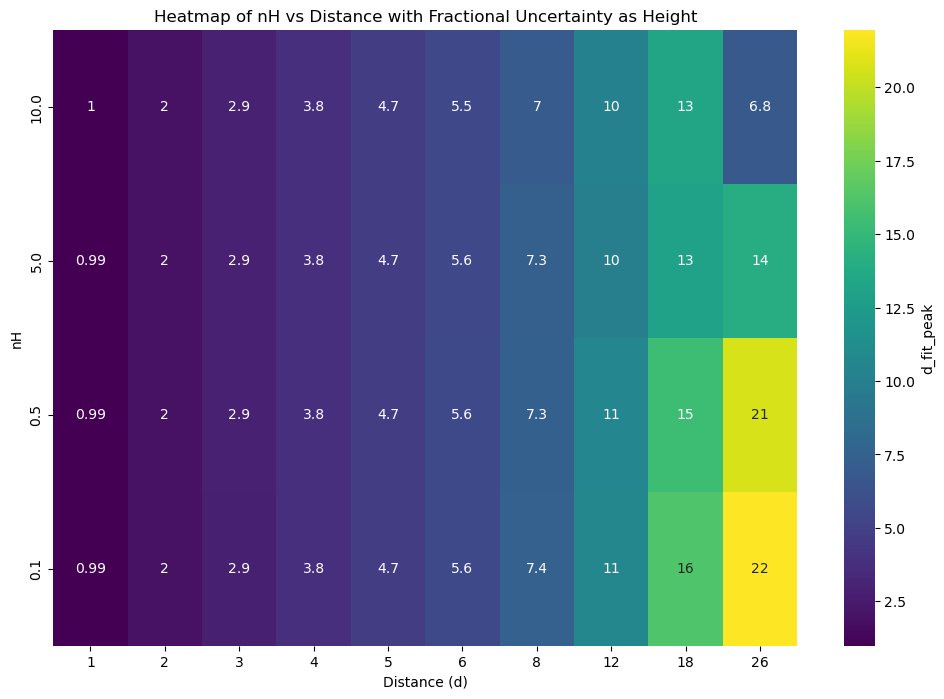

In [15]:
# Concatenate all the data into a single DataFrame
aggregated_data = pd.concat(all_data, ignore_index=True)

# Create a pivot table for the heatmap
heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)

# Sort the index (nH) in ascending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, cbar_kws={'label': central_value})
plt.xlabel('Distance (d)') 
plt.ylabel('nH')
plt.title('Heatmap of nH vs Distance with Fractional Uncertainty as Height')
plt.show()


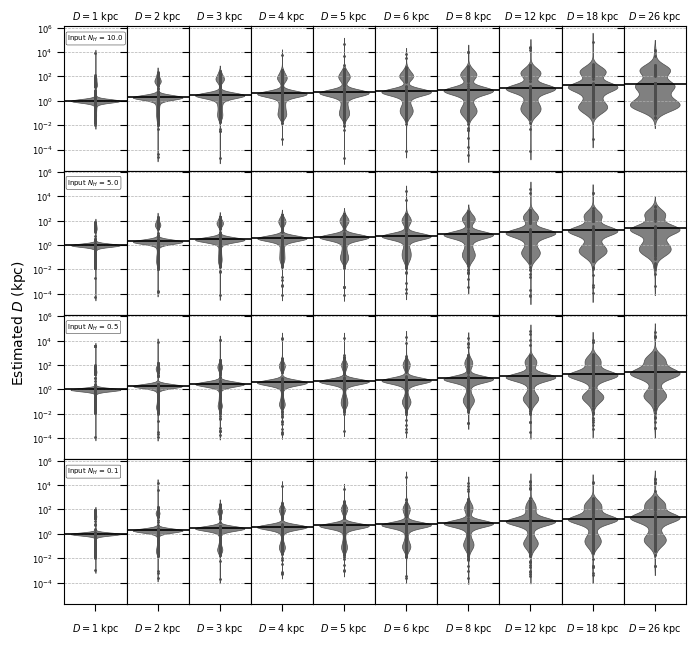

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'nH' and 'd'
grouped_data = aggregated_data.groupby(['nH', 'd'])

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique(), reverse=True)
d_values = sorted(aggregated_data['d'].unique())

# Adjust figure size to fit MNRAS page dimensions
fig_width = 6.974  # MNRAS page width in inches
fig_height_per_row = 1.8  # Adjusted height per row
fig_height = fig_height_per_row * len(nH_values)

fig, axes = plt.subplots(
    len(nH_values), len(d_values),
    figsize=(fig_width, fig_height),
    sharex=True, sharey=True,  # Share x and y axes
    gridspec_kw={'wspace': 0, 'hspace': 0}  # Overlap axes
)

# Get global y-axis limits
all_d_fit_values = aggregated_data[central_value]
# ymin, ymax = all_d_fit_values.min(), all_d_fit_values.max()

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        ax = axes[i, j]

        # Get the distribution of d_fit for each combination of nH and d
        subset = grouped_data.get_group((nH, d))[central_value] if (nH, d) in grouped_data.groups else []
        
        ax.set_yscale('log')
        
        if len(subset) > 0:
            sns.violinplot(y=subset, ax=ax, inner="point", color="grey", linewidth=0.5)
        
        # Reduce grid lines to only major ticks on the y-axis
        ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

        # Set consistent y-axis limits
        # ax.set_ylim(ymin, ymax)

        # Remove the default y-label
        ax.set_ylabel("")

        # Horizontal line for reference
        ax.axhline(y=d_values[j], color="black", linestyle='-', linewidth=1.2)

        # Set titles and labels
        if i == 0:
            ax.set_title(f"$D = {d}$ kpc", fontsize=7, pad=5)  # Font size adjusted
        # if j == 0:
        #     ax.set_ylabel(f"$N_H = {nH}$", fontsize=7, labelpad=2)  # Reduced padding

        if j == 0:  # Only add label once per row
            ax.text(0.05, 0.95, f"Input $N_H$ = {nH}", transform=ax.transAxes,
                    fontsize=5, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2',linewidth=0.3))

        # Add x-axis labels for the bottom row
        if i == len(nH_values) - 1:
            ax.set_xlabel(f"$D = {d}$ kpc", fontsize=7)
            ax.tick_params(axis='x', rotation=45)  # Rotate x-labels

        # Customize ticks
        ax.tick_params(axis='both', which='major', labelsize=6, length=5, width=0.8)
        ax.tick_params(axis='both', which='minor', labelsize=6, length=3, width=0.5)

# Shared ylabel positioned closer to the subplots
fig.text(0.015, 0.5, 'Estimated $D$ (kpc)', va='center', rotation='vertical', fontsize=10)

# Adjust layout to ensure no text overlap
plt.tight_layout(pad=0.8, rect=[0.03, 0.05, 1, 0.95])

# Save the figure as a high-resolution PDF
plt.savefig(f"plots/{instr}/2d_violin_plot_{instr}.png", dpi=300, bbox_inches='tight')
plt.show()


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as ticker

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$m$ ($M_{\odot}$)",                     # Mass in solar masses
    'i': r"$i$ (degrees)",                   # Inclination in degrees
    'r': r"Disk-to-total ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)"                   # Exposure in seconds
}

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
    # Repeat the parameter dictionary for each row in the corresponding data_df
    params_df = pd.DataFrame([params] * len(data_df))
    # Concatenate data and parameters
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Define the parameters to aggregate by
parameters = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    # Create subplots for the current parameter
    fig, axes = plt.subplots(
        len(param_values), 1,
        figsize=(3.3, len(param_values) * 1.5),  # Single-column layout
        sharex=True
    )

    # Iterate through each parameter value and plot distributions
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()

        if not subset.empty:
            subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
            ax.set_yscale('log')  # Use log scale for y-axis
            palette = sns.color_palette('colorblind', len(d_values))  # Colorblind-friendly palette
            sns.violinplot(
                data=subset,
                x='d',
                y=central_value,
                ax=ax,
                hue='d',  # Assign hue to the same as x-axis
                inner=None,  # No internal marks
                palette=palette,
                linewidth=0.3,  # Reduced line width for clarity
                legend=False  # Suppress legend
            )

            # Dynamically calculate the true x-axis limits after padding
            x_limits = ax.get_xlim()
            x_left = x_limits[0]  # True left edge of the axis
            for d_idx, d_value in enumerate(d_values):
                # Get subset of data for the current `d_value`
                data_d_value = subset.loc[subset['d'] == str(d_value), central_value]
                if not data_d_value.empty:
                    x_max = d_idx + 0.3  # Slightly after the violin's center
                    ax.plot([x_left, x_max], [d_value, d_value], color=palette[d_idx], linestyle='-', linewidth=0.5)

        # Add titles using parameter_labels
        ax.set_title(f"{parameter_labels[param]} = {val}", fontsize=7, pad=2)
        ax.set_ylabel("Estimated $D$ (kpc)", fontsize=7, labelpad=2)
        ax.grid(True, which='major', linestyle=':', linewidth=0.3)

        # Adjust tick size to match label font size
        ax.tick_params(axis='both', which='major', labelsize=7, length=3, width=0.3)
        ax.tick_params(axis='both', which='minor', labelsize=7, length=2, width=0.3)

        # Adjust the y-axis ticks explicitly for log scaling
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))  # Max 5 major ticks
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto", numticks=10))  # Minor ticks
        ax.set_xlim(x_limits)

    # Add x-axis label for the bottom plot
    axes[-1].set_xlabel("$D$ (kpc)", fontsize=7)

    # Adjust layout to ensure no overlaps and save the figure
    plt.tight_layout(pad=0.8)
    plt.savefig(f"plots/{instr}/{param}_violin_plot_{instr}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)


In [ ]:
# Plot histograms for each parameter in files that have 'd_fit' = NaN
plt.figure(figsize=(15, 10))
parameter_names = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Iterate over parameters and plot histograms in a 2x3 layout
for idx, param_name in enumerate(parameter_names[:7]):  # Only using the first 6 parameters for the 2x3 layout
    values = [params[param_name] for params in na_d_fit_params if param_name in params]
    plt.subplot(3, 3, idx + 1)
    plt.hist(values, bins=15, edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Parameter: {param_name} (Files with d_fit = NaN)')

plt.tight_layout()
plt.show()

In [ ]:
# Define bin edges
x_bins = [1, 2, 3, 4, 5, 6, 8, 12, 18, 27]
y_bins = [0, 0.5,1, 6.7, 10]

# Plot a 2D histogram for 'nH' and 'd' of non-available distances
plt.figure(figsize=(12, 6))
hist, x_edges, y_edges, im = plt.hist2d(na_distances, na_nH, bins=(x_bins, y_bins), cmap='viridis')
plt.ylabel('nH')
plt.xlabel('Distance (d)')
plt.colorbar(label='Count')
plt.title('2D Histogram of nH and Distance for Non-Available Distances')

# Annotate counts on the cells
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        count = hist[i, j]
        # if count > 0:  # Only annotate non-empty bins
        plt.text((x_edges[i] + x_edges[i + 1]) / 2,
                    (y_edges[j] + y_edges[j + 1]) / 2,
                    int(count),
                    ha='center', va='center', color='white')
                    
plt.show()